# Benchmark : comparaison différents outils Python pour opti bayesienne

Nous allons suivre le plan suivant pour faire un test entre les différentes solutions : 
- Création 4 jeux de données : 
    - 2 de classification binaire (un petit ~10 000 lignes, un plus gros ~1 000 000 lignes)
    - 2 de regression (un petit ~10 000 lignes, un plus gros ~1 000 000 lignes)
- Choix de 3 algorithmes par problématique :
    - Classification : RandomForest, XGBoost et SVM
    - Regression : Regression Linéaire, RandomForest, SVM

Pour ce benchmark nous allons comparer les solutions de recherche d'hyperparamètres suivantes :
- GridSearch
- RandomSearch
- Optimisation Bayesienne :
    - `hyperopt` (utilise TPE)
    - `dragonfly` (utilise GP-UCB)
    - `scikit-optimize` (utilise GP)
    - `BayesianOptimization` (utilise GP)
    - `optuna` (utilise TPE)
    
Les librairies suivantes n'ont pas été retenues :
- Spearmint : déprécié (python 2.7)
- Sigopt : besoin d'un compte
- GPyOpt : n'est plus maintenu


**Critères de comparaisons :**
- Score obtenu sur la CV et sur le test
- temps d'exécution total
- bonus : graphs et détails accessibles pour la recherche
    

## Chargement des librairies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import gc

from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import (
    cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
)
from sklearn.metrics import (
    precision_score, confusion_matrix, accuracy_score, roc_auc_score, make_scorer, recall_score, f1_score)

from hyperopt import hp
from hyperopt.pyll import scope
from scipy.stats import uniform, randint

## Création des jeux de données

In [3]:
dfs = {}

In [4]:
np.random.seed(42)
n_features = 15

X,y = make_classification(n_samples= 10_000,
                          n_features= n_features,
                          n_informative= 10,
                          n_classes= 2,
                          n_repeated= 2,
                          n_redundant= 2,
                          n_clusters_per_class= 3,
                          class_sep= .7,
                          weights= [.6],
                          flip_y= 0,
                          shuffle= False,
                          random_state= 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6)

print('Train')
print(y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

print('Test')
print(y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

dfs['CLF 10 000 rows (.4 pos)'] = (X_train, y_train, X_test, y_test)

Train
(6000,)
0    0.594833
1    0.405167
dtype: float64
Test
(4000,)
0    0.608
1    0.392
dtype: float64


In [5]:
np.random.seed(42)
n_features = 40

X,y = make_classification(n_samples= 10_000,
                          n_features= n_features,
                          n_informative= 30,
                          n_classes= 2,
                          n_repeated= 2,
                          n_redundant= 2,
                          n_clusters_per_class= 3,
                          class_sep= .7,
                          weights= [.1],
                          flip_y= 0,
                          shuffle= False,
                          random_state= 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6)

print('Train')
print(y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

print('Test')
print(y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

dfs['CLF 10 000 rows (.1 pos)'] = (X_train, y_train, X_test, y_test)

Train
(6000,)
1    0.899667
0    0.100333
dtype: float64
Test
(4000,)
1    0.9005
0    0.0995
dtype: float64


In [6]:
np.random.seed(42)
n_features = 30

X,y = make_classification(n_samples= 100_000,
                          n_features= n_features,
                          n_informative= 15,
                          n_classes= 2,
                          n_repeated= 2,
                          n_redundant= 2,
                          n_clusters_per_class= 3,
                          class_sep= .7,
                          weights= [.5],
                          flip_y= 0,
                          shuffle= False,
                          random_state= 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6)

print('Train')
print(y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

print('Test')
print(y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

dfs['CLF 100 000 rows (.5 pos)'] = (X_train, y_train, X_test, y_test)

Train
(60000,)
1    0.500917
0    0.499083
dtype: float64
Test
(40000,)
0    0.501375
1    0.498625
dtype: float64


In [7]:
list(dfs.keys())

['CLF 10 000 rows (.4 pos)',
 'CLF 10 000 rows (.1 pos)',
 'CLF 100 000 rows (.5 pos)']

## Implémentation des algo de recherche

In [8]:
from benchmark_utils import opt_skopt, opt_bayesianopti, opt_hyperopt, opt_optuna, opt_random

In [9]:
# test params
estimator = RandomForestClassifier(n_estimators=30)
scoring = 'accuracy'
cv = 4
n_iter = 3
maximize = True
X_train, y_train, X_test, y_test = dfs['CLF 10 000 rows (.4 pos)']

In [10]:
opt_dict = {}

### GridSearch

In [11]:
param_search = {
    'criterion': ['gini','entropy'],
    'max_depth': [None, 2, 5, 10, 25, 100],
    'max_features': [None, 3, 5, 7, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'min_samples_split': [2, 5, 10, 25, 50],
}
estimator = RandomForestClassifier(n_estimators=30)
scoring = 'accuracy'
cv = 4

# opt = GridSearchCV(estimator, param_search, cv=cv, scoring=scoring)
# opt.fit(X_train, y_train)

### RandomSearch

In [12]:
from scipy.stats import uniform, randint

param_search = {
    'criterion': ['gini','entropy'],
    'max_depth': randint(2, 200),
    'max_features': randint(2,10),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 50),
}

random = opt_random(estimator, param_search, scoring, cv, n_iter, maximize, X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   23.3s finished


In [13]:
random

{'opt': RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(n_estimators=30),
                    n_iter=3, n_jobs=1,
                    param_distributions={'criterion': ['gini', 'entropy'],
                                         'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255FED6BE88>,
                                         'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255FED6BF48>,
                                         'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255FED71448>,
                                         'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255FED71408>},
                    scoring='accuracy', verbose=1),
 'model': RandomForestClassifier(max_depth=74, max_features=4, min_samples_leaf=3,
                        min_samples_split=14, n_estimators=30),
 'best_score_': 0.8678333333333332,
 'results': array([0.85    

### hyperopt (utilise TPE)

In [14]:
from hyperopt import hp
from hyperopt.pyll import scope

# help function : http://hyperopt.github.io/hyperopt/getting-started/search_spaces/
param_hyperopt = {
    'criterion': hp.choice('criterion', ['gini','entropy']),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 200, 1)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
}

res = opt_hyperopt(estimator, param_hyperopt, scoring, cv, n_iter, maximize, X_train, y_train)

100%|██████████| 3/3 [00:23<00:00,  7.86s/trial, best loss: -0.8578333333333332]


In [15]:
res

{'trials': <hyperopt.base.Trials at 0x255fed9bf48>,
 'best_param': {'criterion': 'entropy',
  'max_depth': 67,
  'max_features': 'sqrt',
  'min_samples_leaf': 8,
  'min_samples_split': 22},
 'model': RandomForestClassifier(criterion='entropy', max_depth=67, max_features='sqrt',
                        min_samples_leaf=8, min_samples_split=22,
                        n_estimators=30),
 'best_score_': 0.854,
 'results': [-0.8565, -0.8578333333333332, -0.8464999999999999],
 'idx_best_score': 1,
 'time': 35.6468551158905}

### scikit-optimize (utilise GP)

In [16]:
from bayes_opti_utils import BayesianSearchCV as BayesianSearchCV_skopt

param_search = {
    'criterion': ['gini','entropy'],
    'max_depth': (2, 200),
    'max_features': (2,10),
    'min_samples_leaf': (1, 10),
    'min_samples_split': (2, 50),
}

res = opt_skopt(estimator, param_search, scoring, cv, n_iter, maximize, X_train, y_train)

In [17]:
res

{'opt': <bayes_opti_utils.BayesianSearchCV at 0x255fed9b908>,
 'model': RandomForestClassifier(max_depth=38, max_features=8, min_samples_leaf=6,
                        min_samples_split=23, n_estimators=30, random_state=42),
 'best_score_': 0.8626666666666666,
 'results': array([-0.86266667, -0.85866667, -0.85316667]),
 'idx_best_score': 0,
 'time': 57.57093644142151}

### BayesianOptimization (utilise GP)

In [18]:
from bayes_opt import BayesianOptimization
from scipy.stats import uniform, randint

param_search = {
    'criterion': (0, 2),
    'max_depth': (2, 200),
    'max_features': (2,10),
    'min_samples_leaf': (1, 10),
    'min_samples_split': (2, 50),
}
param_details = {
    'criterion': ['gini','entropy'],
    'max_depth': 'int',
    'max_features': 'int',
    'min_samples_leaf': 'int',
    'min_samples_split': 'int',    
}

res = opt_bayesianopti(estimator, param_search, param_details, scoring, cv, n_iter, maximize, X_train, y_train)

In [19]:
res

{'opt': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x255fed6bb88>,
 'model': RandomForestClassifier(criterion='entropy', max_depth=190, max_features=6,
                        min_samples_leaf=6, min_samples_split=8, n_estimators=30,
                        random_state=42),
 'best_score_': 0.8703333333333334,
 'results': [0.8700000000000001, 0.855, 0.8703333333333334],
 'idx_best_score': 2,
 'time': 51.690571784973145}

### optuna (utilise TPE)

In [20]:
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial
param_search = {
    'criterion': ('categorical', ['gini','entropy']),
    'max_depth': ('int', 2, 200),
    'max_features': ('int', 2,10),
    'min_samples_leaf': ('int', 1, 10),
    'min_samples_split': ('int', 2, 50),
}

res = opt_optuna(estimator, param_search, scoring, cv, n_iter, maximize, X_train, y_train)

[I 2021-02-02 13:02:40,946] A new study created in memory with name: no-name-9ace4ace-1fa8-40ed-8411-32a10d80a520
[I 2021-02-02 13:02:53,123] Trial 0 finished with value: 0.8645 and parameters: {'criterion': 'gini', 'max_depth': 82, 'max_features': 10, 'min_samples_leaf': 9, 'min_samples_split': 5}. Best is trial 0 with value: 0.8645.
[I 2021-02-02 13:02:59,072] Trial 1 finished with value: 0.8443333333333334 and parameters: {'criterion': 'entropy', 'max_depth': 154, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 45}. Best is trial 0 with value: 0.8645.
[I 2021-02-02 13:03:11,708] Trial 2 finished with value: 0.8556666666666666 and parameters: {'criterion': 'gini', 'max_depth': 79, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 49}. Best is trial 0 with value: 0.8645.


In [21]:
res

{'opt': <optuna.study.Study at 0x255fed9b208>,
 'model': RandomForestClassifier(max_depth=82, max_features=10, min_samples_leaf=9,
                        min_samples_split=5, n_estimators=30, random_state=42),
 'best_score_': 0.8645,
 'results': [0.8645, 0.8443333333333334, 0.8556666666666666],
 'idx_best_score': 0,
 'time': 47.634355306625366}

## Benchmark function

In [22]:
def benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, params, scoring, cv, n_iter, maximize, score_fn, n_jobs=1):
    results = {}
    
    clf_base = estimator
    clf_base.fit(X_train, y_train)

    score = cross_val_score(clf_base, X_train, y_train, cv=cv, scoring=scoring, n_jobs=n_jobs).mean()
    score_test = score_fn(clf_base.predict(X_test), y_test)
    
    results['base'] = {
        'best_score_': score,
        'test_score': score_test
    }
    
    print('==== BASE ====')
    print('train best score : %.4f | test score : %.4f'%(score, score_test))
    print()    
    
    for method, (opt_fn, search_params) in params.items() :
        print('Méthode :', method)
        
        if method == 'BayesianOptimization':
            param_details = search_params[1]
            params = search_params[0]
            
            res = opt_fn(estimator, params, param_details, scoring, cv, n_iter, maximize, X_train, y_train, n_jobs=n_jobs)
        else:
            res = opt_fn(estimator, search_params, scoring, cv, n_iter, maximize, X_train, y_train, n_jobs=n_jobs)
        
        test_score = score_fn(res['model'].predict(X_test), y_test)
        res['test_score'] = test_score
        
        results[method] = res
        print('======')
        print('temps écoulé : %.2fs'%res['time'])
        print('train best score : %.4f | test score : %.4f'%(res['best_score_'],res['test_score']))
        print('======')
        print()
        
    return results

### RF param search

In [23]:
random_param = {
    'criterion': ['gini','entropy'],
    'max_depth': randint(2, 200),
    'max_features': randint(2,10),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 50),
}
bayesopt_param = {
    'criterion': (0, 2),
    'max_depth': (2, 200),
    'max_features': (2,10),
    'min_samples_leaf': (1, 10),
    'min_samples_split': (2, 50),
}
bayesopt_details = {
    'criterion': ['gini','entropy'],
    'max_depth': 'int',
    'max_features': 'int',
    'min_samples_leaf': 'int',
    'min_samples_split': 'int',    
}
optuna_param = {
    'criterion': ('categorical', ['gini','entropy']),
    'max_depth': ('int', 2, 200),
    'max_features': ('int', 2,10),
    'min_samples_leaf': ('int', 1, 10),
    'min_samples_split': ('int', 2, 50),
}
skopt_param = {
    'criterion': ['gini','entropy'],
    'max_depth': (2, 200),
    'max_features': (2,10),
    'min_samples_leaf': (1, 10),
    'min_samples_split': (2, 50),
}
hyperopt_param = {
    'criterion': hp.choice('criterion', ['gini','entropy']),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 200, 1)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
}

In [24]:
clf_rf_params = {
    'RandomSearch': (opt_random, random_param),
    'skopt': (opt_skopt, skopt_param),
    'BayesianOptimization': (opt_bayesianopti, [bayesopt_param, bayesopt_details]),
    'optuna': (opt_optuna, optuna_param),
    'hyperopt': (opt_hyperopt, hyperopt_param),
}

### XGB Param search

In [25]:
from skopt.space.space import Real, Integer, Categorical

random_param = {
    'max_depth': randint(2, 200),
    'subsample': uniform(.6, .4),
    'colsample_bytree': uniform(.6, .4),
    'colsample_bylevel': uniform(.6, .4),
    'min_child_weight': uniform(.1, 10),
    'gamma': uniform(0, 1),
    'eta': uniform(.01, .4),
}
bayesopt_param = {
    'max_depth': (2, 200),
    'subsample': (.6, 1),
    'colsample_bytree': (.6, 1),
    'colsample_bylevel': (.6, 1),
    'min_child_weight': (.1, 10),
    'gamma': (0, 1),
    'eta': (.01, .4),
}
bayesopt_details = {
    'max_depth': 'int',
    'subsample': 'float',
    'colsample_bytree': 'float',
    'colsample_bylevel': 'float',
    'min_child_weight': 'float',
    'gamma': 'float',
    'eta': 'float',    
}
optuna_param = {
    'max_depth': ('int', 2, 200),
    'subsample': ('uniform', .6, 1),
    'colsample_bytree': ('uniform', .6, 1),
    'colsample_bylevel': ('uniform', .6, 1),
    'min_child_weight': ('uniform', .1, 10),
    'gamma': ('uniform', 0, 1),
    'eta': ('uniform', .01, .4),
}
skopt_param = {
    'max_depth': Integer(2, 200),
    'subsample': Real(.6, 1),
    'colsample_bytree': Real(.6, 1),
    'colsample_bylevel': Real(.6, 1),
    'min_child_weight': Real(.1, 10),
    'gamma': Real(0, 1),
    'eta': Real(.01, .4),
}
hyperopt_param = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 200, 1)),
    'subsample': hp.uniform('subsample', .6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', .6, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', .6, 1),
    'min_child_weight': hp.uniform('min_child_weight', .6, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'eta': hp.uniform('eta', .01, .4),
}

In [26]:
clf_xgb_params = {
    'RandomSearch': (opt_random, random_param),
    'skopt': (opt_skopt, skopt_param),
    'BayesianOptimization': (opt_bayesianopti, [bayesopt_param, bayesopt_details]),
    'optuna': (opt_optuna, optuna_param),
    'hyperopt': (opt_hyperopt, hyperopt_param),
}

### Param SVM

In [27]:
from sklearn.svm import SVC

In [28]:
from scipy.stats import loguniform

random_param = {
    'kernel': ['poly', 'rbf'],
    'gamma': loguniform(1e-5, 1e-2),
    'C': loguniform(1, 1000),
}

bayesopt_param = {
    'kernel': (0,4),
    'gamma': (1e-5, 1e-2),
    'C': (1, 1000),
}
bayesopt_details = {
    'kernel':  ['poly', 'rbf'],
    'gamma': 'float',
    'C': 'float',
}
optuna_param = {
    'kernel': ('categorical', ['poly', 'rbf']),
    'gamma': ('loguniform', 1e-5, 1e-2),
    'C': ('loguniform', 1, 1000),
}
skopt_param = {
    'kernel': ['poly', 'rbf'],
    'gamma': Real(1e-5, 1e-2, prior='log-uniform'),
    'C': Real(1, 1000, prior='log-uniform'),
}
hyperopt_param = {
    'kernel': hp.choice('kernel', [ 'poly', 'rbf']),
    'gamma': hp.qloguniform('gamma', 1e-5, 1e-2, 1),
    'C': hp.qloguniform('C', 1, 1000, 1),
}

In [29]:
clf_svm_params = {
    'RandomSearch': (opt_random, random_param),
    'skopt': (opt_skopt, skopt_param),
    'BayesianOptimization': (opt_bayesianopti, [bayesopt_param, bayesopt_details]),
    'optuna': (opt_optuna, optuna_param),
#     'hyperopt': (opt_hyperopt, hyperopt_param),
}

### Fonctions utils

In [30]:
import joblib

def format_results(res):
    res_format = {}
    ignore_keys = ['opt']
    
    for method, opt in res.items():
        tmp = {}
        for k, v in opt.items():
            if k in ignore_keys:
                continue
            tmp[k] = v
        res_format[method] = tmp
    
    return res_format

def save_results(res, fpath):
    results_formated = format_results(res)
    
    with open(fpath, 'wb') as file:
        joblib.dump(results_formated, file, compress='gzip')

In [31]:
def plot_convergence(results):
    fig, ax = plt.subplots(figsize=(12,7))
    
    for k, opt in results.items():
        if k == 'base':
            continue
        scores = -np.abs(opt['results'])
        
        hist_score = [scores[0]]
        for s in scores[1:]:
            hist_score += [np.min([hist_score[-1], s])]
        
        ax.plot(range(1,len(hist_score)+1), hist_score, label=k)
        ax.scatter(range(1,len(hist_score)+1), hist_score, s=20)
    
    ax.legend()
    ax.set_title('Convergence of different hyperparameter tuning methods')
    ax.set_xlabel('iteration')
    ax.set_ylabel('score')
    ax.grid()
    
    plt.show()
    
def get_results_as_df(res):
    cols = ['train_score','idx_best_score','time','test_score']

    train_score = [v['best_score_'] for (k,v) in res.items() if k != 'base']
    idx_best_score = [v['idx_best_score'] for (k,v) in res.items() if k != 'base']
    times = [v['time'] for (k,v) in res.items() if k != 'base']
    test_score = [v['test_score'] for(k,v) in res.items() if k != 'base']
    # params = [v['model'].get_params() for v in results.values()]

    data = [train_score, idx_best_score, times, test_score]

    res_df = pd.DataFrame(data, index=cols, columns=list(res.keys())[1:]).T
    
    return res_df

## Launch benchmark

### RF Classifier

In [32]:
import xgboost as xgb
import warnings
import optuna

optuna.logging.set_verbosity(0)
warnings.filterwarnings('ignore')

In [33]:
results = {}

In [34]:
scoring = 'accuracy'
cv = 3
n_iter = 70
maximize = True
score_fn = accuracy_score

In [35]:
dfs.keys()

dict_keys(['CLF 10 000 rows (.4 pos)', 'CLF 10 000 rows (.1 pos)', 'CLF 100 000 rows (.5 pos)'])

### Dataset : 10 000 lignes (40% positif), metric : accuracy

#### RF

In [118]:
estimator = RandomForestClassifier(n_estimators=50)
df_name = 'CLF 10 000 rows (.4 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_rf_params, scoring, cv, n_iter, maximize, score_fn)

results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_rf_10000_40prct.sav.gzip')

==== BASE ====
train best score : 0.8768 | test score : 0.8822

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  2.7min finished


temps écoulé : 164.41s
train best score : 0.8798 | test score : 0.8920

Méthode : skopt
temps écoulé : 308.68s
train best score : 0.8833 | test score : 0.8945

Méthode : BayesianOptimization
temps écoulé : 227.18s
train best score : 0.8840 | test score : 0.8928

Méthode : optuna
temps écoulé : 303.38s
train best score : 0.8858 | test score : 0.8912

Méthode : hyperopt
100%|██████████| 70/70 [01:44<00:00,  1.49s/trial, best loss: -0.8808333333333334]
temps écoulé : 107.19s
train best score : 0.8808 | test score : 0.8928



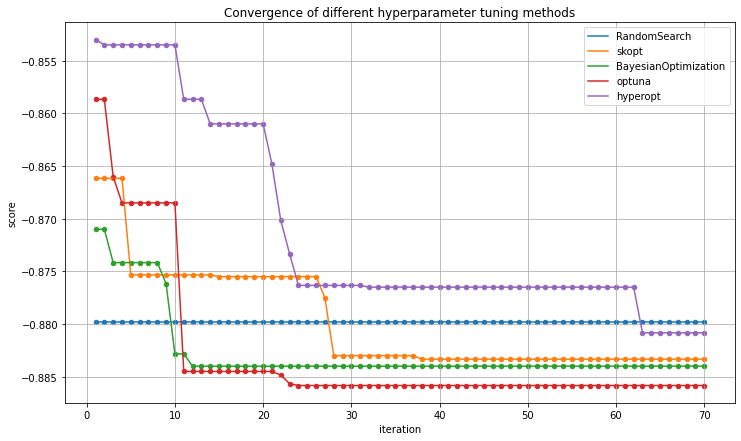

In [119]:
plot_convergence(res)

In [144]:
df_name = 'CLF 10 000 rows (.4 pos)'
res = results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.883333,37.0,308.675633,0.89450
BayesianOptimization,0.884000,11.0,227.183776,0.89275
hyperopt,0.880833,62.0,107.192346,0.89275
RandomSearch,0.879833,0.0,164.409045,0.89200
optuna,0.885833,23.0,303.377071,0.89125


#### XGB

In [121]:
estimator = xgb.XGBClassifier(n_estimators=50, objective = "binary:logistic", eval_metric = "logloss")
df_name = 'CLF 10 000 rows (.4 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_xgb_params, scoring, cv, n_iter, maximize, score_fn)

results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_xgb_10000_40prct.sav.gzip')

==== BASE ====
train best score : 0.8830 | test score : 0.8938

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.3min finished


temps écoulé : 80.18s
train best score : 0.8935 | test score : 0.9008

Méthode : skopt
temps écoulé : 180.73s
train best score : 0.8990 | test score : 0.9062

Méthode : BayesianOptimization
temps écoulé : 112.09s
train best score : 0.8983 | test score : 0.9045

Méthode : optuna
temps écoulé : 123.50s
train best score : 0.9018 | test score : 0.9060

Méthode : hyperopt
100%|██████████| 70/70 [01:56<00:00,  1.66s/trial, best loss: -0.8971666666666667]
temps écoulé : 118.26s
train best score : 0.8972 | test score : 0.9040



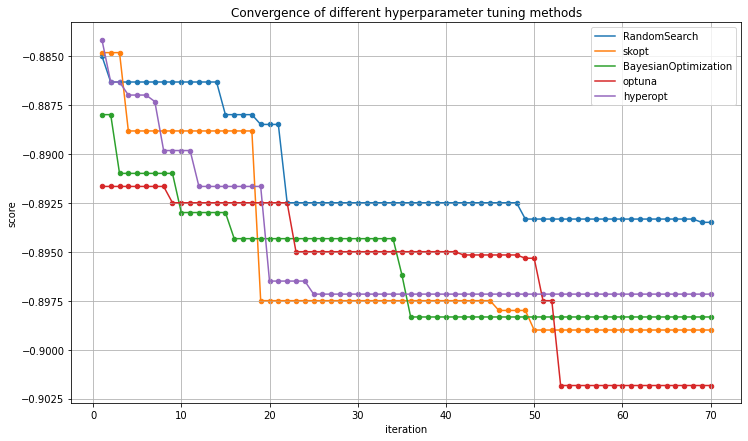

In [122]:
plot_convergence(res)

In [145]:
df_name = 'CLF 10 000 rows (.4 pos)'
res = results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.899000,49.0,180.730585,0.90625
optuna,0.901833,52.0,123.498244,0.90600
BayesianOptimization,0.898333,35.0,112.094309,0.90450
hyperopt,0.897167,24.0,118.264393,0.90400
RandomSearch,0.893500,68.0,80.181544,0.90075


#### SVM

In [36]:
clf_svm_params = {
    'RandomSearch': (opt_random, random_param),
    'skopt': (opt_skopt, skopt_param),
    'BayesianOptimization': (opt_bayesianopti, [bayesopt_param, bayesopt_details]),
    'optuna': (opt_optuna, optuna_param),
#     'hyperopt': (opt_hyperopt, hyperopt_param),
}

In [37]:
estimator = SVC()
df_name = 'CLF 10 000 rows (.4 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_svm_params, scoring, cv, n_iter, maximize, score_fn, n_jobs=3)

results['SVM -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_svm_10000_40prct.sav.gzip')

==== BASE ====
train best score : 0.8963 | test score : 0.9042

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   41.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed:  2.8min finished


temps écoulé : 185.20s
train best score : 0.9207 | test score : 0.9210

Méthode : skopt
temps écoulé : 604.00s
train best score : 0.9228 | test score : 0.9277

Méthode : BayesianOptimization
temps écoulé : 948.58s
train best score : 0.9212 | test score : 0.9147

Méthode : optuna
temps écoulé : 214.11s
train best score : 0.9225 | test score : 0.9275



In [38]:
gc.collect()

412

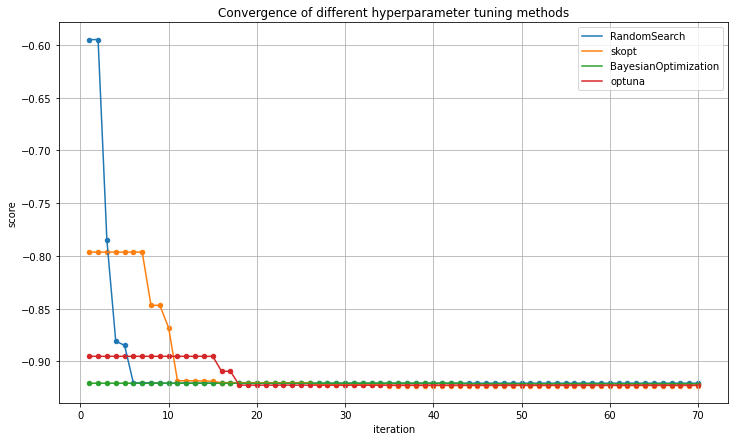

In [39]:
df_name = 'CLF 10 000 rows (.4 pos)'
res = results['SVM -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
plot_convergence(res)

In [40]:
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.922833,34.0,603.996701,0.92775
optuna,0.922500,17.0,214.113230,0.92750
RandomSearch,0.920667,8.0,185.196692,0.92100
BayesianOptimization,0.921167,43.0,948.583159,0.91475


### Dataset : 10 000 lignes (10% positif), metric : f1 score

#### RF

In [41]:
scoring = 'f1'

In [130]:
estimator = RandomForestClassifier(n_estimators=50)
df_name = 'CLF 10 000 rows (.1 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_rf_params, scoring, cv, n_iter, maximize, score_fn)

results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_rf_10000_10prct.sav.gzip')

==== BASE ====
train best score : 0.9487 | test score : 0.9045

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  3.1min finished


temps écoulé : 190.47s
train best score : 0.9483 | test score : 0.9040

Méthode : skopt
temps écoulé : 314.23s
train best score : 0.9499 | test score : 0.9083

Méthode : BayesianOptimization
temps écoulé : 319.84s
train best score : 0.9491 | test score : 0.9045

Méthode : optuna
temps écoulé : 312.24s
train best score : 0.9483 | test score : 0.9038

Méthode : hyperopt
100%|██████████| 70/70 [03:55<00:00,  3.37s/trial, best loss: -0.9480988885722037]
temps écoulé : 241.37s
train best score : 0.9481 | test score : 0.9038



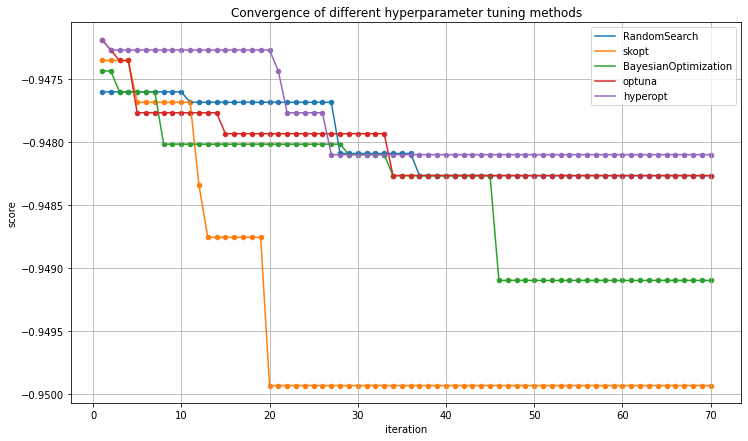

In [132]:
plot_convergence(res)

In [146]:
df_name = 'CLF 10 000 rows (.1 pos)'
res = results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.949935,19.0,314.229724,0.90825
BayesianOptimization,0.949099,45.0,319.840899,0.90450
RandomSearch,0.948266,36.0,190.466790,0.90400
optuna,0.948265,33.0,312.243119,0.90375
hyperopt,0.948099,26.0,241.370649,0.90375


#### XGB

In [134]:
estimator = xgb.XGBClassifier(n_estimators=50, objective = "binary:logistic", eval_metric = "logloss")
df_name = 'CLF 10 000 rows (.1 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_xgb_params, scoring, cv, n_iter, maximize, score_fn)

results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_xgb_10000_10prct.sav.gzip')

==== BASE ====
train best score : 0.9584 | test score : 0.9280

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  1.9min finished


temps écoulé : 112.49s
train best score : 0.9604 | test score : 0.9267

Méthode : skopt
temps écoulé : 166.26s
train best score : 0.9601 | test score : 0.9293

Méthode : BayesianOptimization
temps écoulé : 129.24s
train best score : 0.9606 | test score : 0.9280

Méthode : optuna
temps écoulé : 113.30s
train best score : 0.9603 | test score : 0.9270

Méthode : hyperopt
100%|██████████| 70/70 [02:40<00:00,  2.30s/trial, best loss: -0.959022787958104] 
temps écoulé : 162.62s
train best score : 0.9590 | test score : 0.9215



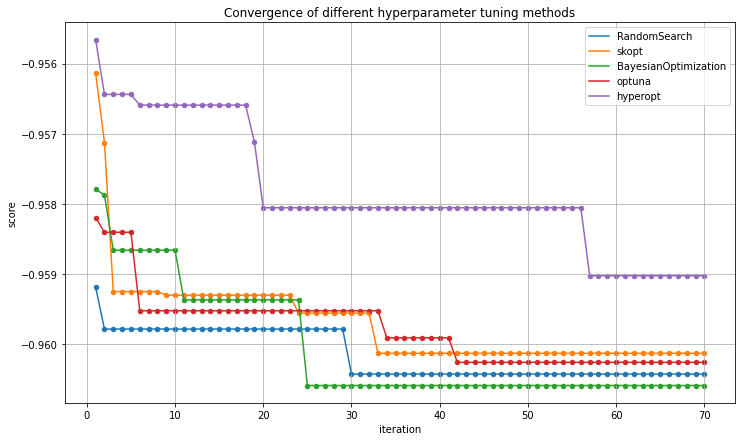

In [135]:
plot_convergence(res)

In [147]:
df_name = 'CLF 10 000 rows (.1 pos)'
res = results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.960128,32.0,166.261286,0.92925
BayesianOptimization,0.960587,24.0,129.239904,0.92800
optuna,0.960257,41.0,113.297766,0.92700
RandomSearch,0.960424,29.0,112.489041,0.92675
hyperopt,0.959023,56.0,162.621888,0.92150


#### SVM

In [44]:
estimator = SVC()
df_name = 'CLF 10 000 rows (.1 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_svm_params, scoring, cv, n_iter, maximize, score_fn)

results['SVM -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_svm_10000_10prct.sav.gzip')

==== BASE ====
train best score : 0.9680 | test score : 0.9465

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  9.3min finished


temps écoulé : 561.55s
train best score : 0.9807 | test score : 0.9677

Méthode : skopt
temps écoulé : 763.13s
train best score : 0.9816 | test score : 0.9688

Méthode : BayesianOptimization
temps écoulé : 1315.70s
train best score : 0.9810 | test score : 0.9692

Méthode : optuna
temps écoulé : 596.84s
train best score : 0.9813 | test score : 0.9698



In [45]:
gc.collect()

214

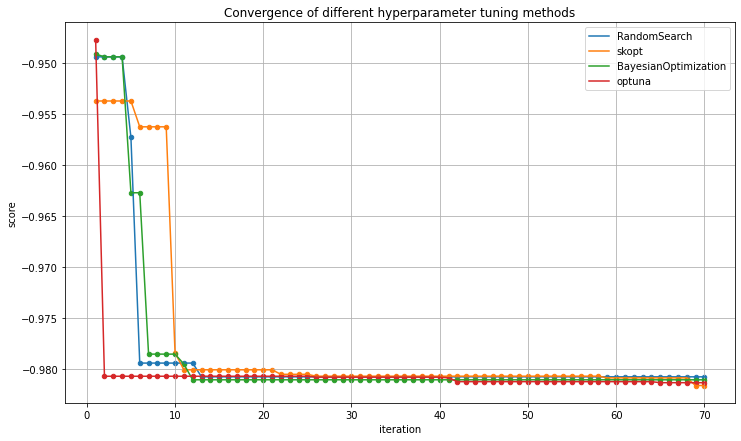

In [46]:
df_name = 'CLF 10 000 rows (.1 pos)'
res = results['SVM -%s - %i iter - CV %i'%(df_name, n_iter, cv)]
plot_convergence(res)

In [47]:
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
optuna,0.981319,64.0,596.839946,0.96975
BayesianOptimization,0.981035,11.0,1315.704954,0.96925
skopt,0.981596,68.0,763.133048,0.96875
RandomSearch,0.980745,12.0,561.546506,0.96775


### Dataset : 1 000 000 lignes (50% positif), metric : accuracy

#### RF

In [28]:
dfs.keys()

dict_keys(['CLF 10 000 rows (.4 pos)', 'CLF 10 000 rows (.1 pos)', 'CLF 1 000 000 rows (.5 pos)', 'CLF 100 000 rows (.5 pos)'])

In [29]:
scoring = 'accuracy'

In [30]:
estimator = RandomForestClassifier(n_estimators=50)
df_name = 'CLF 100 000 rows (.5 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_rf_params, scoring, cv, n_iter, maximize, score_fn, n_jobs=3)

results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_rf_100000_50prct.sav.gzip')

==== BASE ====
train best score : 0.8985 | test score : 0.9072

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 22.9min
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed: 24.8min finished


temps écoulé : 1514.63s
train best score : 0.8969 | test score : 0.9101

Méthode : skopt
temps écoulé : 2083.70s
train best score : 0.9018 | test score : 0.9130

Méthode : BayesianOptimization
temps écoulé : 1773.65s
train best score : 0.9020 | test score : 0.9100

Méthode : optuna
temps écoulé : 1711.56s
train best score : 0.9002 | test score : 0.9108

Méthode : hyperopt
100%|██████████| 70/70 [24:18<00:00, 20.83s/trial, best loss: -0.8973833333333333]
temps écoulé : 1593.06s
train best score : 0.8974 | test score : 0.9067



In [31]:
gc.collect()

204

In [32]:
df_name = 'CLF 100 000 rows (.5 pos)'
res = results['RF -%s - %i iter - CV %i'%(df_name, n_iter, cv)]

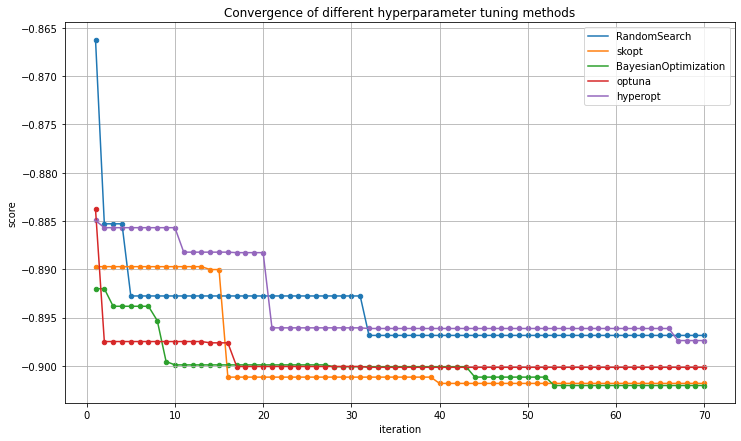

In [33]:
plot_convergence(res)

In [34]:
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
skopt,0.901817,39.0,2083.696280,0.912975
optuna,0.900150,31.0,1711.556025,0.910825
RandomSearch,0.896850,31.0,1514.627317,0.910100
BayesianOptimization,0.902033,52.0,1773.646472,0.910000
hyperopt,0.897383,66.0,1593.055864,0.906725


#### XGB

In [35]:
estimator = xgb.XGBClassifier(n_estimators=50, objective = "binary:logistic", eval_metric = "logloss")
df_name = 'CLF 100 000 rows (.5 pos)'
X_train, y_train, X_test, y_test = dfs[df_name]
res = benchmark_baye_opt(X_train, y_train, X_test, y_test, estimator, clf_xgb_params, scoring, cv, n_iter, maximize, score_fn, n_jobs=3)

results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)] = res
save_results(res, fpath='res/clf_xgb_100000_50prct.sav.gzip')

==== BASE ====
train best score : 0.8999 | test score : 0.9047

Méthode : RandomSearch
Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 29.8min
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed: 32.3min finished


temps écoulé : 1955.18s
train best score : 0.9320 | test score : 0.9422

Méthode : skopt
temps écoulé : 2607.98s
train best score : 0.9335 | test score : 0.9405

Méthode : BayesianOptimization
temps écoulé : 2073.40s
train best score : 0.9326 | test score : 0.9401

Méthode : optuna
temps écoulé : 2282.76s
train best score : 0.9332 | test score : 0.9394

Méthode : hyperopt
100%|██████████| 70/70 [42:32<00:00, 36.46s/trial, best loss: -0.9317833333333333]
temps écoulé : 2632.43s
train best score : 0.9318 | test score : 0.9390



In [36]:
gc.collect()

72

In [37]:
df_name = 'CLF 100 000 rows (.5 pos)'
res = results['XGB -%s - %i iter - CV %i'%(df_name, n_iter, cv)]

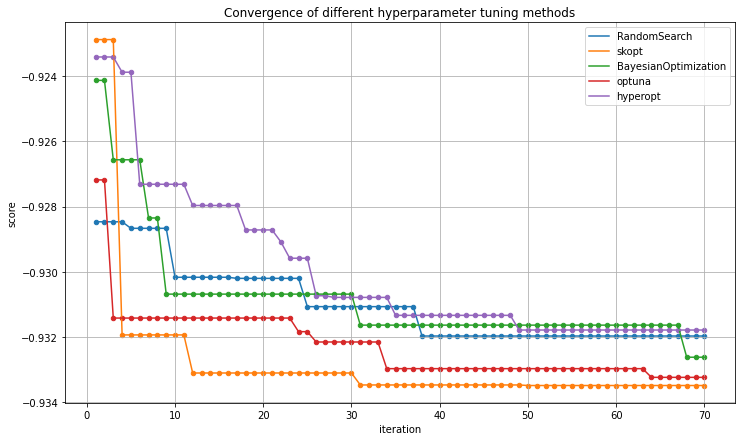

In [38]:
plot_convergence(res)

In [39]:
get_results_as_df(res).sort_values(['test_score','train_score'], ascending=False)

,train_score,idx_best_score,time,test_score
RandomSearch,0.931967,37.0,1955.178202,0.942225
skopt,0.933483,49.0,2607.981022,0.940525
BayesianOptimization,0.932617,67.0,2073.395979,0.940125
optuna,0.933233,63.0,2282.761767,0.939400
hyperopt,0.931783,48.0,2632.430414,0.939000


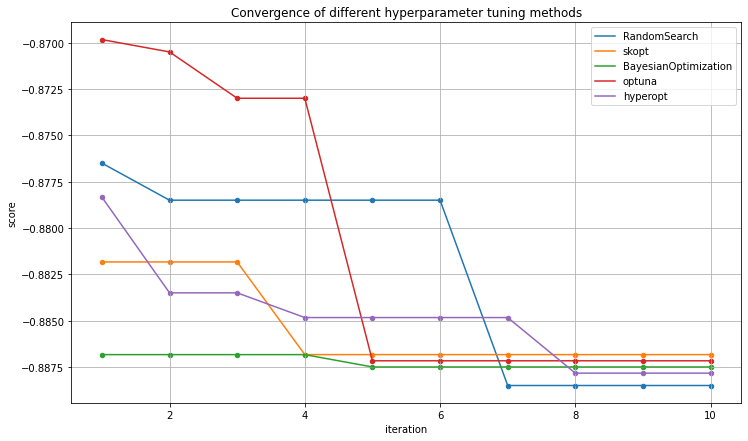

In [104]:
plot_convergence(results['XGB -CLF 10 000 rows (.4 pos) - 10 iter - CV 3'])

In [114]:
get_results_as_df(results['XGB -CLF 10 000 rows (.4 pos) - 10 iter - CV 3'])

,train_score,idx_best_score,time,test_score
RandomSearch,0.888500,6.0,5.896104,0.89525
skopt,0.886833,3.0,9.695935,0.89550
BayesianOptimization,0.887500,4.0,12.549435,0.89700
optuna,0.887167,4.0,8.754959,0.89725
hyperopt,0.887833,7.0,11.559999,0.88950


In [55]:
param_search = {
    'criterion': ['gini','entropy'],
    'max_depth': (2, 200),
    'max_features': (2,10),
    'min_samples_leaf': (1, 10),
    'min_samples_split': (2, 50),
}
estimator = RandomForestClassifier(n_estimators=30)

opt = BayesianSearchCV_skopt(
    estimator,
    param_search,
    n_iter=50,
    cv=3,
    n_jobs=4,
    scoring='accuracy',
    random_state=42,
    maximize=True, 
    
    n_initial_points=20,
#     init_params=init_params,
    exploration_decay=0.5,
    exploration_min=0.001,
    
#     acq_func="EI", acq_optimizer="sampling",
    acq_func_kwargs = {"xi": 100, "kappa": 100}
)

opt.fit(X_train, y_train)

{'xi': 100, 'kappa': 100}
{'xi': 50.0, 'kappa': 50.0}
{'xi': 25.0, 'kappa': 25.0}
{'xi': 12.5, 'kappa': 12.5}
{'xi': 6.25, 'kappa': 6.25}
{'xi': 3.125, 'kappa': 3.125}
{'xi': 1.5625, 'kappa': 1.5625}
{'xi': 0.78125, 'kappa': 0.78125}
{'xi': 0.390625, 'kappa': 0.390625}
{'xi': 0.1953125, 'kappa': 0.1953125}
{'xi': 0.09765625, 'kappa': 0.09765625}
{'xi': 0.048828125, 'kappa': 0.048828125}
{'xi': 0.0244140625, 'kappa': 0.0244140625}
{'xi': 0.01220703125, 'kappa': 0.01220703125}
{'xi': 0.006103515625, 'kappa': 0.006103515625}
{'xi': 0.0030517578125, 'kappa': 0.0030517578125}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi': 0.00152587890625, 'kappa': 0.00152587890625}
{'xi':

In [76]:
score = cross_val_score(opt.best_estimator_, X_train, y_train, cv=cv, scoring=scoring).mean()
score_test = score_fn(opt.best_estimator_.predict(X_test), y_test)
print('train CV score :', score)
print('test score :', score_test)

train CV score : 0.8774292397995893
test score : 0.8863333333333333


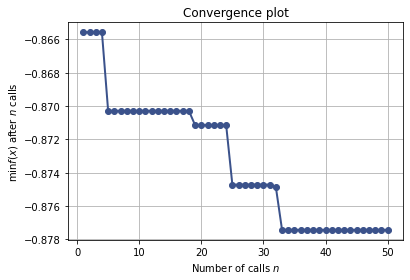

In [59]:
opt.plot_convergence()

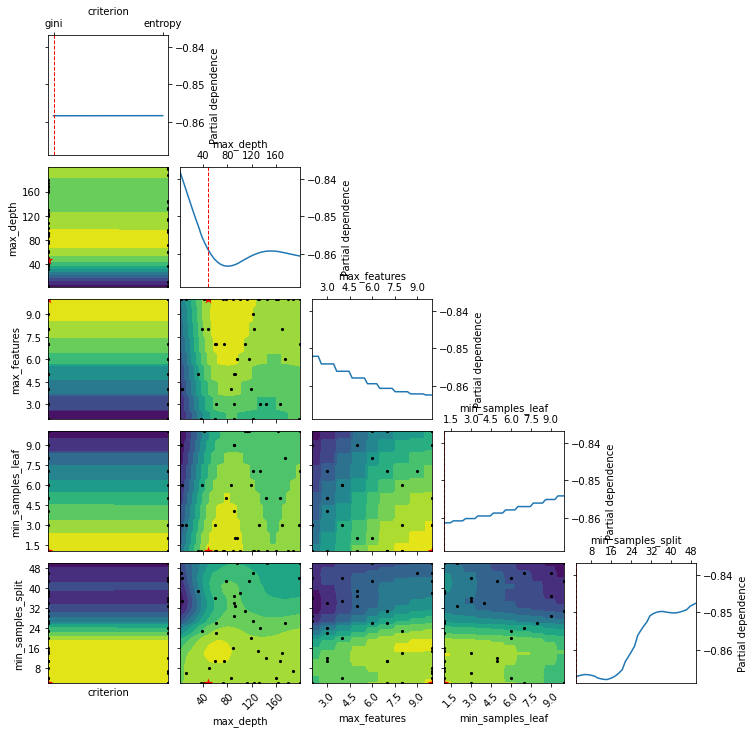

In [73]:
opt.plot_objective()